It is an unexpected result for the transcriptomics to outperform the proteomics, as we would expect for the most part, proteins to be closer to phenotype and mechanism than RNA. 

Here, we hypothesize that this may be due to the fact that transcriptomics covers a larger fraction of the genome than proteomics, resulting in more comprehensive coverage, including geneds more informative of metastatic mechanisms. This may be likely for two reasons: 1) the transcriptomics didn't outperform the proteomics too strongly (by MSE effect size and no significant comparisons in Pearson), and 2) the proteomics gained its performance with a smaller subset of total features, whereas transcriptomics required all features.

In the previous notebook, we down-samples the sumple numbers of the transcriptomics as a comparison. Here, we will also downsample the transcriptomic features to that of the protein dataset to see how this effects model performance. 

In [17]:
# see section 2.3 for details of this
subset_intersect_unbias = False

In [18]:
import os
import json
from tqdm import tqdm, trange

import pandas as pd
import numpy as np
from scipy import stats
import statistics
from sklearn.neighbors import KernelDensity


import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object, cohen_d

In [19]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 1024

from threadpoolctl import threadpool_limits
n_cores = 64
for v in ["OMP_NUM_THREADS","MKL_NUM_THREADS","OPENBLAS_NUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[v] = "1" # 1 thread per process; CV handles parallelism

# Map Features

Load the files:

In [20]:
# protein
expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
protein_cols = expr_protein.columns

mp_protein = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)

X_protein = expr_protein.values
y_protein = mp_protein['mean'].values.ravel()

# rna
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)
rna_cols = expr_rna.columns
mp_rna = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)

X_rna = expr_rna.values
y_rna = mp_rna['mean'].values.ravel()


In [21]:
# # map from uniprot ID to gene name
# import mygene
# uniprot_ids = list(set([protein_id.split('|')[1].split('-')[0] for protein_id in protein_cols]))
# mg = mygene.MyGeneInfo()
# uid_maps = mg.querymany(uniprot_ids, scopes="uniprot", fields="symbol", species="human")
# uid_mapper = {pn.get('query'): pn.get('symbol', np.nan) for pn in uid_maps}
# with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "w") as json_file:
#     json.dump(uid_mapper, json_file, indent=4)

with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "r") as json_file:
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
'P16189': 'HLA-A',
'P30456': 'HLA-A',
'P30443': 'HLA-A',
'P05534': 'HLA-A',
'P18462': 'HLA-A',
'P01892': 'HLA-A',
'P13746': 'HLA-A',
'P01891': 'HLA-A',
'P30483': 'HLA-B',
'P30484': 'HLA-B',
'P03989': 'HLA-B',
'P30460': 'HLA-B',
'P30461': 'HLA-B',
'Q95365': 'HLA-B',
'P16188': 'HLA-A',
'Q95604': 'HLA-C',
'Q07000': 'HLA-C',
'P30499': 'HLA-C',
'P30501': 'HLA-C',
'P30504': 'HLA-C',
'Q95IE3': 'HLA-DRB1',
'P04229': 'HLA-DRB1',
'P20039': 'HLA-DRB1',
'P13760': 'HLA-DRB1',
'Q5Y7A7': 'HLA-DRB1',
'Q9GIY3': 'HLA-DRB1',
'Q9TQE0': 'HLA-DRB1',
'Q30134': 'HLA-DRB1'}
    
protein_names = []
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names.append(gene_name)
# n_protein_names = len(set(protein_names))

In [22]:
rna_names = [rna_id.split(' (')[0] for rna_id in rna_cols]
# protein_names = [protein_id.split('|')[-1].split('_HUMAN')[0] for protein_id in protein_cols]
intersect_names = set(rna_names).intersection(protein_names)

n_features = [len(rna_names), len(protein_names), len(intersect_names)]
print('Of the {} RNA features and {} protein features, there are {} features in common'.format(*n_features))

rna_map = dict(zip(rna_cols, rna_names))
protein_map = dict(zip(protein_cols, protein_names))

Of the 16371 RNA features and 10969 protein features, there are 10202 features in common


# Top Transcriptomics Features

First, let's see how many of the top transcriptomic features are present in the proteomic dataset, as well as how the rankings compare to the features selected in the proteomics model. The expectation is, that if our hypothesis is true, the top transcriptomic features are ones that are not present in proteomics (and thus, proteomics is just missing measurement of genes that are informative of metastasis).  

For proteomics, since there was no significant differences between consensus models from [notebook 03](./03_predict_proteomics.ipynb) and since the linear SVR had the highest rank, and since linear SVR makes this more directly comparable to transcriptomics, we proceed with it. This consensus model had only 5000 features selected.

For feature comparisons, we re-fit the consensus models on the entire datasets (no train/test splits). 

Load and fit the models:

In [23]:
# protein
best_pipeline_protein = read_pickled_object(os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))
best_pipeline_protein.fit(X_protein, y_protein)

# rna
best_pipeline_rna = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline_rna.fit(X_rna, y_rna)


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [24]:
def get_ranked_coefs(best_pipeline, gene_map, gene_cols):
    model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
    model_indices = best_pipeline.named_steps['feature_reduction'].top_indices_
    selected_cols = [gene_cols[i] for i in model_indices]

    model_coefs = pd.DataFrame(data = {'SVM coefficient': model_coefs},
                                    index = selected_cols)
    model_coefs['Gene_Name'] = model_coefs.index.map(gene_map)
    model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
    model_coefs.reset_index(names = 'feature', inplace = True)
    
    
    model_coefs['abs_SVM_rank'] = (
        model_coefs['SVM coefficient']
        .abs()
        .rank(method='min', ascending=False)
        .astype(int)
    )
    
    return model_coefs

## Fraction present

In [25]:
model_coefs_protein = get_ranked_coefs(best_pipeline_protein, protein_map, protein_cols)
selected_protein_genes = set(model_coefs_protein.Gene_Name)

In [26]:
model_coefs_rna = get_ranked_coefs(best_pipeline_rna, rna_map, rna_cols)

model_coefs_rna['in_protein_all'] = False
isin_protein = model_coefs_rna[model_coefs_rna.Gene_Name.isin(protein_names)].index
model_coefs_rna.loc[isin_protein, 'in_protein_all'] = True
model_coefs_rna['in_protein_all'] = pd.Categorical(model_coefs_rna.in_protein_all, 
                                              ordered = True, 
                                              categories = [True, False])

model_coefs_rna['in_protein_selected'] = False
isin_protein = model_coefs_rna[model_coefs_rna.Gene_Name.isin(selected_protein_genes)].index
model_coefs_rna.loc[isin_protein, 'in_protein_selected'] = True
model_coefs_rna['in_protein_selected'] = pd.Categorical(model_coefs_rna.in_protein_selected, 
                                              ordered = True, 
                                              categories = [True, False])


In [27]:
model_coefs_rna['fraction_overlap_all'] = np.nan
model_coefs_rna['fraction_overlap_selected'] = np.nan
for rank in tqdm(model_coefs_rna.index):
    ffa = model_coefs_rna.loc[:rank, 'in_protein_all'].value_counts()[True]/(rank + 1)
    model_coefs_rna.loc[rank, 'fraction_overlap_all'] = ffa
    
    ffs = model_coefs_rna.loc[:rank, 'in_protein_selected'].value_counts()[True]/(rank + 1)
    model_coefs_rna.loc[rank, 'fraction_overlap_selected'] = ffs
    
model_coefs_rna['feature_rank'] = model_coefs_rna.index+1


100%|████████████████████████████████████████████████████████████████████████████████████| 16371/16371 [00:07<00:00, 2330.46it/s]


## Correlation in Model Coefficients

In [28]:
rna_genes = model_coefs_rna.Gene_Name.tolist()
protein_genes = model_coefs_protein.Gene_Name.tolist()
intersect_genes = sorted(set(rna_genes).intersection(protein_genes))

print('Of the {} features in the RNA model and the {} features in the protein model, {} overlap'.format(
    len(rna_genes), len(protein_genes), len(intersect_genes)
))


common_col = 'SVM coefficient'
modality_ranker = 'Transcriptomics'

model_coefs_joint = []
for (col_name, model_coefs_) in {'Transcriptomics': model_coefs_rna, 'Proteomics': model_coefs_protein}.items():
#     model_coefs = model_coefs_.copy()
#     model_coefs[common_col] = model_coefs[common_col].abs()
    
    model_coefs = pd.DataFrame(model_coefs_.groupby('Gene_Name')[common_col].mean())
    model_coefs.columns = [col_name]
    model_coefs = model_coefs.loc[intersect_genes, :].copy()
    model_coefs_joint.append(model_coefs)
    
model_coefs_joint = pd.concat(model_coefs_joint, axis = 1)


model_coefs_joint['{} Feature Rank'.format(modality_ranker)] = (
        model_coefs_joint[modality_ranker]
        .abs()
        .rank(method='min', ascending=False)
        .astype(int)
    )

model_coefs_joint.sort_values(by = '{} Feature Rank'.format(modality_ranker), ascending = True, inplace = True)

Of the 16371 features in the RNA model and the 5000 features in the protein model, 4654 overlap


In [29]:
rank_pearson = {'{} Feature Rank'.format(modality_ranker): [], 'Pearson Correlation': []}
for i in range(4, model_coefs_joint.shape[0]):
    svm_ranked_coefs = model_coefs_joint.iloc[:i,:]
    r, p = stats.pearsonr(svm_ranked_coefs.Transcriptomics, svm_ranked_coefs.Proteomics)
    rank_pearson['{} Feature Rank'.format(modality_ranker)].append(model_coefs_joint.iloc[i, :]['{} Feature Rank'.format(modality_ranker)])
    rank_pearson['Pearson Correlation'].append(r)
    
rank_pearson = pd.DataFrame(rank_pearson)

''

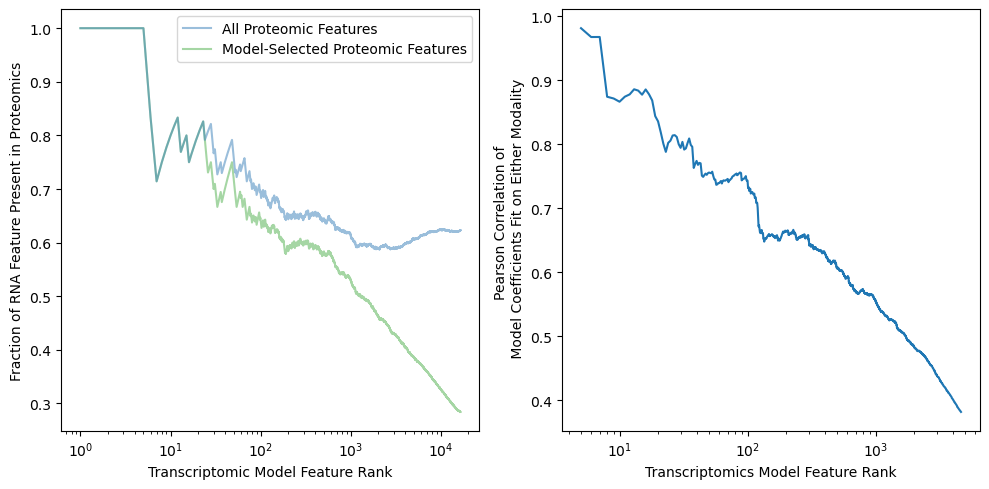

In [31]:
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)


i = 0

viz_df = model_coefs_rna.copy()
viz_df['rank'] = [i +1 for i in viz_df.index.tolist()]




sns.lineplot(data = viz_df, x = 'rank', y = 'fraction_overlap_all', ax = ax[i], 
             color = sns.color_palette('Set1')[1], alpha=0.5,
             label = 'All Proteomic Features', zorder = 1,
            )
sns.lineplot(data = viz_df, x = 'rank', y = 'fraction_overlap_selected', ax = ax[i], 
             color = sns.color_palette('Set1')[2], alpha = 0.5,
             label = 'Model-Selected Proteomic Features', zorder = 0)
ax[i].set_xscale('log')
ax[i].set_xlabel('Transcriptomic Model Feature Rank')
ax[i].set_ylabel('Fraction of RNA Feature Present in Proteomics')

i = 1
rank_pearson = pd.DataFrame(rank_pearson)
sns.lineplot(data = rank_pearson, x = '{} Feature Rank'.format(modality_ranker), y = 'Pearson Correlation', ax = ax[i])
ax[i].set_xlabel('{} Model Feature Rank'.format(modality_ranker))
ax[i].set_xscale('log')
ax[i].set_ylabel('Pearson Correlation of \n Model Coefficients Fit on Either Modality')
;


fig.tight_layout()

plt.savefig(os.path.join(data_path, 'figures', 'intersection_rank.png'), 
            dpi=300, 
            bbox_inches="tight")  
;

In [32]:
model_coefs_rna[model_coefs_rna['feature_rank'].isin([1, 5, 100, 500])][
    ['feature_rank', 'fraction_overlap_all', 'fraction_overlap_selected']
]

,feature_rank,fraction_overlap_all,fraction_overlap_selected
0,1,1.000,1.000
4,5,1.000,1.000
99,100,0.690,0.640
499,500,0.644,0.582


We're looking for support of the hypothesis that: transcriptomics models outperform proteomics due to higher genome-wide coverage in measurement.
    
On the left panel, we see the fraction of transcriptomic features at that rank that are present in proteomics (either all proteomics features or model-selected proteomics features). 

Considering the blue line, all proteomics features, ff our hypothesis is true, we would expect that at higher ranks, there would be fewer features present in transcriptomics than at lower ranks. Here, the overall trend indicates the opposite of our hypothesis: those features most important for the transcriptomics model are in fact present in the proteomics dataset. However, it is important to keep in mind that this can be more nuanced: for example, in the top 5-100 features, the overlap drops from 100% to 70%. It is possible that that missing 30% of features makes all the difference in model performance. 

This is supported when looking only at selected features in the proteomic model (green line) -- amongst the top 500 and even 1000 features, this overlap does not drop off steeply from all proteomic features (i.e., green line mirrors blue line). This indicates that when the same high ranking features *are* available to the proteomics model, it will use them. 

Finally, we can look specifically at how the model uses those same features. We: 

1) Subset to the overlapping selected features between the two models (taking the mean SVM coefficient) in instances of many to one mappings)
2) x-axis: Rank order by absolute value SVM coefficient of the transcriptomcis model. 
3) y-axis: At a given feature rank, calculate the Pearson correlation of the SVM coefficient 

Nearly all selected proteomics models were present in transcriptomics. This allowed us to assess similarity of model fits between the two modalities. Across all common features, atleast a moderate Pearson correlation is maintained. This further supports the notion that when a gene is measured by both assays, the proteomics and transcriptomics models agree strongly on its importance and direction. This is consistent with results in Notebook C/04

It brings up an interesting secondary point, which is that this seems to indicate that the two modalities carry similar information on phenotype. The slight discrepancy between the green and blue line could indicate those instances where the two modalities carry distinct information. Altogether, this brings up an important question: How similar is the information on phenotype between the two modalities, and how would a model with access to both simultaneously utilize these similarities/dissimilarities? We will address this more in Notebook C. 

## Relative Rank of Non-Intersecting Genes

This is simply a sanity check that we are not removing just non-negligible (low-rank) genes from one modality but very important genes from the other. For example, if we had an enrichment of un-important genes we were removing in transcriptomics, we would expect model performance to increase because we are reducing the dimensionality (since samples << features). Or, if we only removed important genes from proteomics and unimportant ones from transcriptomics, this would bias analyses. 

Thus, we take the normalized rank of each features from consensus models fit on the full feature space of each modality and look at the distribution of the non-intersecting genes (those that are dropped). 

In [33]:
normalized_coefs = []
for model_coefs in [model_coefs_rna, model_coefs_protein]:
    model_coefs = model_coefs[['Gene_Name', 'abs_SVM_rank']].copy()
    model_coefs['normalized_rank'] = (model_coefs['abs_SVM_rank'] - 1) / (model_coefs['abs_SVM_rank'].max() - 1)
    model_coefs['does_intersect'] = model_coefs.Gene_Name.isin(intersect_names).copy()
    normalized_coefs.append(model_coefs)
normalized_coefs_rna, normalized_coefs_protein = normalized_coefs

normalized_coefs_map = {
    'Transcriptomics': normalized_coefs_rna, 
    'Proteomics': normalized_coefs_protein
}

''

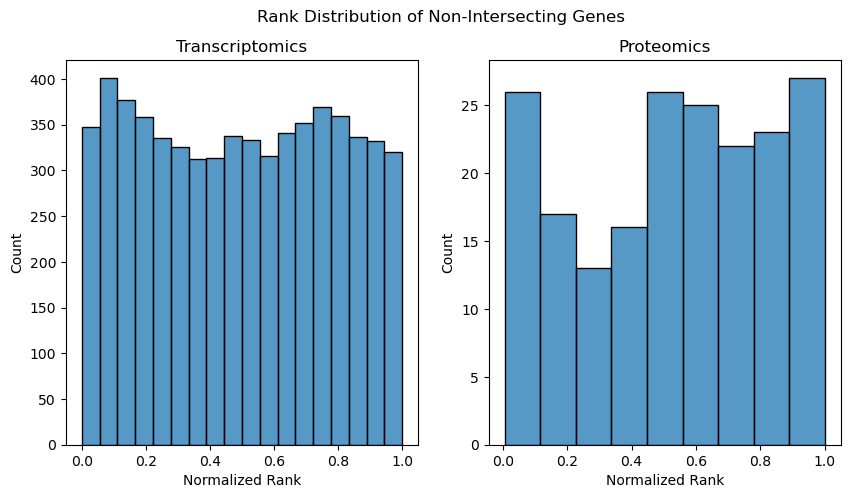

In [70]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

for (i, modality) in enumerate(['Transcriptomics', 'Proteomics']):
    normalized_coefs = normalized_coefs_map[modality]
    mask = ~(normalized_coefs.does_intersect)
    
    sns.histplot(data = normalized_coefs.loc[mask], x = 'normalized_rank', ax = ax[i])
    ax[i].set_title(modality)
    ax[i].set_xlabel('Normalized Rank')
    
fig.suptitle('Rank Distribution of Non-Intersecting Genes')
;

Ok, this looks reasonable. However, we can see that the tail ends of either rank are opposing, so there is some bias. Let's see if we can identify a subset of 95% of intersecting features that makes this smoother. We'll just use a brute force approach, iterating 2e4 times and creating subsets, quantifying them by the Anderson-Darling statistic and choosing the one that minimizes the average across the two distributions. 

In [71]:
def get_normalized_rank(model_coefs, intersect_names):
    normalized_coefs = model_coefs[['Gene_Name', 'abs_SVM_rank']].copy()
    normalized_coefs['normalized_rank'] = (normalized_coefs['abs_SVM_rank'] - 1) / (normalized_coefs['abs_SVM_rank'].max() - 1)
    normalized_coefs['does_intersect'] = normalized_coefs.Gene_Name.isin(intersect_names).copy()
    
    normalized_coefs = normalized_coefs[~normalized_coefs.does_intersect]
    
    return normalized_coefs


# def normalized_entropy(ranks):
#     ranks = ranks.reshape(-1, 1)
#     kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(ranks)
#     log_p = kde.score_samples(ranks)
#     p = np.exp(log_p)
#     p /= p.sum()
#     H = -np.sum(p * np.log(p + 1e-12))
#     return H / np.log(len(p))

def anderson_darling_uniform(ranks):
    r = np.sort(ranks)
    n = len(r)
    i = np.arange(1, n+1)
    term = (2*i - 1) * (np.log(r + 1e-12) + np.log(1 - r[::-1] + 1e-12))
    A2 = -n - np.mean(term)
    return A2

def ad_corrected(ranks):
    r = np.sort(ranks)
    n = len(r)
    i = np.arange(1, n+1)
    A2 = -n - np.mean((2*i - 1) * (np.log(r + 1e-12) + np.log(1 - r[::-1] + 1e-12)))
    return A2 * (1 + 0.75/n + 2.25/n**2)





In [72]:
subset_frac = 0.95
total_iter = int(2e4)

n_total_intersect = len(intersect_names)
n_subset_intersect = int(np.round(subset_frac*n_total_intersect))

In [73]:


modality_map = {
    'Transcriptomics': model_coefs_rna, 
    'Proteomics': model_coefs_protein
}

sorted_intersect_names = sorted(intersect_names) # for no randomness

if not os.path.isfile(os.path.join(data_path, 'interim', "intersect_features_subset.txt")):
    # initial values:
    scores = []
    for modality, model_coefs in modality_map.items():
        normalized_coefs = get_normalized_rank(model_coefs, intersect_names)
        score = ad_corrected(normalized_coefs.normalized_rank.values)
        scores.append(score)

    best_scores = scores
    best_score = 0.5 * (scores[0] + scores[1])
    best_intersect = intersect_names

    np.random.seed(random_state)
    for i in trange(total_iter):
        intersect_names_sub = list(np.random.choice(sorted_intersect_names, size = n_subset_intersect, replace = False))

        scores = []
        for modality, model_coefs in modality_map.items():
            normalized_coefs = get_normalized_rank(model_coefs, intersect_names_sub)
            score = ad_corrected(normalized_coefs.normalized_rank.values)
            scores.append(score)
        score = 0.5 * (scores[0] + scores[1])

        if score < best_score:
            best_scores = scores
            best_score = score
            best_intersect = intersect_names_sub

    with open(os.path.join(data_path, 'interim', "intersect_features_subset.txt"), "w") as f:
        for item in best_intersect:
            f.write(str(item) + "\n")
else:
    with open(os.path.join(data_path, 'interim', "intersect_features_subset.txt"), "r") as f:
        best_intersect = [line.strip() for line in f]

    

''

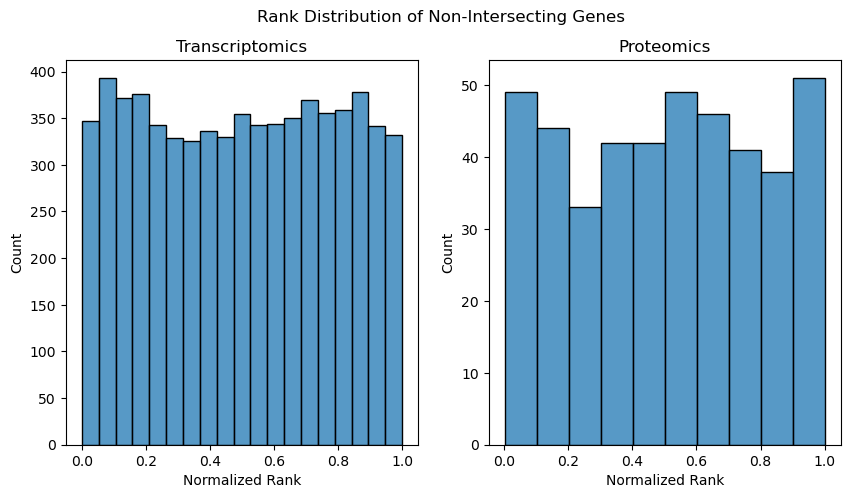

In [74]:
normalized_coefs_map = {}
for modality, model_coefs in modality_map.items():
    normalized_coefs_map[modality] = get_normalized_rank(model_coefs, best_intersect)
    
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

for (i, modality) in enumerate(['Transcriptomics', 'Proteomics']):
    normalized_coefs = normalized_coefs_map[modality]
    mask = ~(normalized_coefs.does_intersect)
    
    sns.histplot(data = normalized_coefs.loc[mask], x = 'normalized_rank', ax = ax[i])
    ax[i].set_title(modality)
    ax[i].set_xlabel('Normalized Rank')
    
fig.suptitle('Rank Distribution of Non-Intersecting Genes')
;

We can see that there is less tail bias for both distributions after selecting a 95% subset of intersecting genes. 

In [75]:
if subset_intersect_unbias:

    rna_cols_intersect = [rna_cols[i] for i, rna_name in enumerate(rna_names) if rna_name in intersect_names]
    protein_cols_intersect = [protein_cols[i] for i, protein_name in enumerate(protein_names) if protein_name in intersect_names]


    # RNA
    N = expr_rna.shape[1]
    n = len(rna_cols_intersect)

    msg = 'When taking the full intersection, {} of {} RNA features are dropped, leaving {} total '.format(
        N-n, N, n
    )
    msg += 'The fraction of total features dropped is {:.4f}'.format((N-n)/N)
    msg += '\n\n'

    # Protein
    N = expr_protein.shape[1]
    n = len(protein_cols_intersect)


    msg += 'When taking the full intersection, {} of {} protein features are dropped, leaving {} total '.format(
        N-n, N, n
    )
    msg += 'The fraction of total features dropped is {:.4f}'.format((N-n)/N)
    msg += '\n\n'

    N_selected = model_coefs_protein.shape[0]
    n_selected = np.sum(model_coefs_protein['Gene_Name'].isin(intersect_genes))
    msg += 'For proteomics, {} of the {} selected features are dropped, leaving {} total from the original selected list'.format(
        N_selected - n_selected, N_selected, n_selected
    )
    msg += 'The fraction of features dropped is {:.4f}'.format((N_selected - n_selected)/N_selected)

    print(msg)
    print('=====================================Intersect Subset==============================================')
    ### subset

    rna_cols_intersect = [rna_cols[i] for i, rna_name in enumerate(rna_names) if rna_name in best_intersect]
    protein_cols_intersect = [protein_cols[i] for i, protein_name in enumerate(protein_names) if protein_name in best_intersect]


    # RNA
    N = expr_rna.shape[1]
    n = len(rna_cols_intersect)

    msg = 'When taking the subsetted intersection, {} of {} RNA features are dropped, leaving {} total '.format(
        N-n, N, n
    )
    msg += 'The fraction of total features dropped is {:.4f}'.format((N-n)/N)
    msg += '\n\n'

    # Protein
    N = expr_protein.shape[1]
    n = len(protein_cols_intersect)


    msg += 'When taking the subsetted intersection, {} of {} protein features are dropped, leaving {} total '.format(
        N-n, N, n
    )
    msg += 'The fraction of total features dropped is {:.4f}'.format((N-n)/N)
    msg += '\n\n'

    N_selected = model_coefs_protein.shape[0]
    n_selected = np.sum(model_coefs_protein['Gene_Name'].isin(best_intersect))
    msg += 'For proteomics, {} of the {} selected features are dropped, leaving {} total from the original selected list'.format(
        N_selected - n_selected, N_selected, n_selected
    )
    msg += 'The fraction of features dropped is {:.4f}'.format((N_selected - n_selected)/N_selected)

    print(msg)




We see that when we use this intersect, a slightly higher portion of transcriptomic and proteomic features were dropped than before. 
The loss of proteomics is stronger than transcriptomics; however, we will still be using the same intersection, and now with less bias in the rank removal, so this is a more fair test. 


# Intersection with Proteomic Features

Here, we re-run our prediction pipeline, starting again from hyperparameter tuning. We proceed with the linear SVRs as explained above. However, to make the comparison fair, in this case, for both transcriptomics and proteomics, we start with the intersection of features. Furthermore, we only use the samples in common between the two (similar to the power analysis).

In [34]:
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.base import clone

import optuna
from optuna.samplers import CmaEsSampler, TPESampler, RandomSampler

from utils import MeanCenterer, HybridSampler, RandomTPESampler
from utils import RNAFeatureSelector, ProteinFeatureSelector
from utils import get_stats

In [35]:
feature_selector_map = {'Transcriptomics': RNAFeatureSelector, 
                     'Proteomics': ProteinFeatureSelector}

## Map samples between proteomics and transcriptomics:

In [36]:
md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr_protein.index = pd.Series(expr_protein.index).apply(lambda x: x.split('_')[0])

sample_mapper = md[md.StrippedCellLineName.isin(expr_protein.index)]
sample_mapper = dict(zip(sample_mapper.StrippedCellLineName, sample_mapper.index))
if len(sample_mapper) != expr_protein.shape[0]:
    raise ValueError('Expect all samples to be mapped')
expr_protein.index = expr_protein.index.map(sample_mapper)
mp_protein.index = expr_protein.index

with open(os.path.join(data_path, 'processed', 'proteomics_sample_mapper.json'), "w") as json_file:
    json.dump(sample_mapper, json_file, indent=4)

In [37]:
common_samples = sorted(set(expr_protein.index).intersection(expr_rna.index))
print('Of the {} and {} samples in protein and RNA datasets, respectively, {} are shared'.format(expr_protein.shape[0], 
                                                                                                expr_rna.shape[0], 
                                                                                                len(common_samples)))



Of the 248 and 481 samples in protein and RNA datasets, respectively, 247 are shared


In [38]:
expr_protein_common = expr_protein.loc[common_samples, :]
expr_rna_common = expr_rna.loc[common_samples, :]
mp_common = mp_protein.loc[common_samples, :]

y_common = mp_common['mean'].values.ravel()

## Hyperparameter tuning

This is conducted on all samples available to each dataset, as previously described in notebooks A/02 and B/02: 

In [39]:
intersect_genes = intersect_names.copy() if not subset_intersect_unbias else set(best_intersect)

rna_cols_intersect = [rna_cols[i] for i, rna_name in enumerate(rna_names) if rna_name in intersect_genes]
protein_cols_intersect = [protein_cols[i] for i, protein_name in enumerate(protein_names) if protein_name in intersect_genes]

n_protein_features = len(protein_cols_intersect) 
n_rna_features = len(rna_cols_intersect)
if n_protein_features != n_rna_features:
    msg = 'Due to a lack of 1-to-1 mapping between protein and RNA features, '
    msg += 'taking the intersection between them results in {} '.format(n_protein_features)
    msg += 'protein features and {} RNA features'.format(n_rna_features)
    print(msg)
    print('')
    
    msg = 'Compare this to the starting amount of features for each: '
    msg += ' {} and {} for protein and RNA, respectively'.format(len(protein_cols), len(rna_cols))
    print(msg)


Due to a lack of 1-to-1 mapping between protein and RNA features, taking the intersection between them results in 10560 protein features and 10202 RNA features

Compare this to the starting amount of features for each:  10969 and 16371 for protein and RNA, respectively


In [40]:
def optuna_objective(trial, X, y, inner_cv, n_cores, random_state, modality):
    model_type = 'SVR_linear'
    
    # Define feature reduction/selection method
    FeatureSelector = feature_selector_map[modality]
    steps = [
        ("feature_reduction", FeatureSelector(method="top_residuals", 
                                              n_features=trial.suggest_categorical("FeatureSelector__n_features", [250, 500, 1000, 5000, X.shape[1]]))),
        ("mean_centering", MeanCenterer()),
    ]

    steps.append(("model", SVR(
        kernel='linear',
        C=trial.suggest_float(model_type + "__C", 1e-4, 1e2, log = True),
        epsilon=trial.suggest_float(model_type + "__epsilon", 1e-3, 10, log=True)
    )))
#     # computational speed up
#     steps.append(("model", LinearSVR(
#         C=trial.suggest_float(model_type + "__C", 1e-4, 1e2, log=True),
#         epsilon=trial.suggest_float(model_type + "__epsilon", 1e-3, 10, log=True),
#         random_state=random_state,
#         max_iter=int(1e4)
#     )))

    # Create the pipeline
    pipeline = Pipeline(steps)

    # Evaluate with cross-validation
    mse = -cross_val_score(pipeline, X, y, 
                           cv=inner_cv, 
                           scoring="neg_mean_squared_error", 
                           n_jobs=inner_cv.n_splits).mean()

    return mse

def generate_best_pipeline(study, modality):
    FeatureSelector = feature_selector_map[modality]
    best_params = study.best_params
    steps = []
    steps.append(("feature_reduction", FeatureSelector(method="top_residuals", n_features=best_params["FeatureSelector__n_features"])))
    steps.append(("mean_centering", MeanCenterer()))
    
    steps.append(("model", SVR(
        kernel='linear',
        C=best_params["SVR_linear__C"],
        epsilon=best_params['SVR_linear__epsilon']
    )))
#     steps.append(("model", LinearSVR(
#         C=best_params["SVR_linear__C"],
#         epsilon=best_params["SVR_linear__epsilon"],
#         random_state=random_state,
#         max_iter=int(1e4)
#     )))
    
    
    best_pipeline = Pipeline(steps)
    return best_pipeline



In [41]:
X_protein = expr_protein_common[protein_cols_intersect].copy().values
X_rna = expr_rna_common[rna_cols_intersect].copy().values


outer_folds=10
inner_folds=5
n_trials = 100

In [42]:
def initialize_sampler(seed):

    cmaes_sampler = CmaEsSampler(seed=random_state, 
                                 warn_independent_sampling=False, 
                                restart_strategy='bipop')

    exploration_sampler = RandomSampler(seed=seed)
    tpe_sampler = RandomTPESampler(seed=seed, 
                                   n_startup_trials = 15,
                                   exploration_sampler = exploration_sampler, 
                                   exploration_freq=20 # randomly sample every n trials
                                  )
    
    hybrid_sampler = HybridSampler(primary_sampler=cmaes_sampler, fallback_sampler=tpe_sampler)
    
    return hybrid_sampler

In [43]:
if subset_intersect_unbias:
    fn = os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv')
    fn_folds = os.path.join(data_path, 'interim', 'feature_intersection_folds.json')
else:
    fn = os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect_nosubset.csv.csv')
    fn_folds = os.path.join(data_path, 'interim', 'feature_intersection_folds_nosubset.json')

In [44]:
# outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
# inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)

# if not os.path.isfile(fn):
#     results = []
#     res_df = None
# else:
#     res_df = pd.read_csv(fn, index_col = 0)
#     results = res_df.to_dict(orient="records")

# fold_idx = {}
# for k, (train_idx, test_idx) in enumerate(outer_cv.split(X_protein, y_common)):
#     print(k)
    
#     fold_idx[k] = {'train_idx': train_idx.tolist(), 
#                       'test_idx': test_idx.tolist()}
    
#     y_train, y_test = y_common[train_idx], y_common[test_idx]

#     X = {'Proteomics': {}, 
#         'Transcriptomics': {}}

#     X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
#     X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]

#     for modality in X:
#         # skip existing results
#         if res_df is not None:
#             mask = (res_df.fold == k) & (res_df.modality == modality)
#             if mask.any():
#                 continue
        
#         hybrid_sampler = initialize_sampler(seed = random_state) # + k)
#         pruner = optuna.pruners.SuccessiveHalvingPruner()
#         study = optuna.create_study(direction="minimize", 
#                                     sampler=hybrid_sampler, 
#                                    pruner = pruner, 
#                                    study_name = '{}_optuna'.format(k))
#         study.optimize(
#             lambda trial: optuna_objective(trial, X[modality]['train'], y_train, inner_cv, n_cores, random_state, modality),
#             n_trials=n_trials, 
#             catch=(ValueError,)
#         )
        
#         best_pipeline = generate_best_pipeline(study, modality)
#         best_pipeline.fit(X[modality]['train'], y_train)

#         y_train_pred = best_pipeline.predict(X[modality]['train'])
#         y_test_pred = best_pipeline.predict(X[modality]['test'])

#         train_corr = pearsonr(y_train, y_train_pred)[0]
#         test_corr = pearsonr(y_test, y_test_pred)[0]
#         train_mse = mean_squared_error(y_train, y_train_pred)
#         test_mse = mean_squared_error(y_test, y_test_pred)
        
#         results.append({
#             "modality": modality,
#             "fold": k,
#             "train_corr": train_corr,
#             "test_corr": test_corr,
#             "train_mse": train_mse,
#             "test_mse": test_mse,
#             "best_params": study.best_params,
#             "inner_cv": study.trials_dataframe()
#             })
#         res_df = pd.DataFrame(results)
#         res_df.to_csv(fn)


# with open(fn_folds, "w") as json_file:
#     json.dump(fold_idx, json_file, indent=4) 
        
        
## read in
res_df = pd.read_csv(fn, index_col = 0)
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])
with open(fn_folds, "r") as f:
    fold_idx = json.load(f)
fold_idx = {int(k): v for k,v in fold_idx.items()}


# Intersection Analysis

## Feature Uniqueness and Model Performance

In [63]:
def jaccard(a, b):
    a, b = set(a), set(b)
    return len(a & b) / len(a | b)

In [46]:
# if not os.path.isfile(os.path.join(data_path, 'interim', 'intersect_features_jaccard.csv')):

    # use the same split to get the top genes
#     outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
feature_names = {'Transcriptomics': rna_cols_intersect, 'Proteomics': protein_cols_intersect}
feature_map = {'Transcriptomics': rna_map, 'Proteomics': protein_map}


features_res = {'n_features_Transcriptomics': [], 'n_features_Proteomics': [], 
               'jaccard_index': []}
#     for k, (train_idx, _) in enumerate(outer_cv.split(X_protein, y_common)): 

for (k, splits) in tqdm(fold_idx.items()):
    train_idx = splits['train_idx']
    test_idx = splits['test_idx']

    y_train = y_common[train_idx]
    X = {
        'Proteomics': X_protein[train_idx], 
        'Transcriptomics': X_rna[train_idx]
    }
    # get top genes
    mask = (res_df.fold == k)


    sf = {}
    for modality in ['Transcriptomics', 'Proteomics']:
        mask_modality = mask & (res_df.modality == modality)
        n_features_modality = eval(res_df.loc[mask_modality, 'best_params'].tolist()[0])['FeatureSelector__n_features']

        # get selected features
        fs = feature_selector_map[modality](method="top_residuals", n_features=n_features_modality)
        fs.fit(X = X[modality], y = y_train)
        selected_features = [feature_names[modality][i] for i in fs.top_indices_]

        # map to common name
        selected_features = [feature_map[modality][i] for i in selected_features]

        features_res['n_features_{}'.format(modality)].append(n_features_modality)
        sf[modality] = selected_features

    features_res['jaccard_index'].append(jaccard(sf['Transcriptomics'], sf['Proteomics']))

features_res = pd.DataFrame(features_res)
# features_res.to_csv(os.path.join(data_path, 'interim', 'intersect_features_jaccard.csv'))
# else:
#     features_res = pd.read_csv(os.path.join(data_path, 'interim', 'intersect_features_jaccard.csv'), index_col =0)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]


In [89]:
for modality in ['Transcriptomics', 'Proteomics']:
    print(features_res['n_features_{}'.format(modality)].value_counts())

n_features_Transcriptomics
10202    7
5000     2
1000     1
Name: count, dtype: int64
n_features_Proteomics
5000    8
500     1
1000    1
Name: count, dtype: int64


In [90]:
print('More transcriptomics features are selected than proteomics features in {} of {} folds'.format(
    np.sum(features_res.n_features_Transcriptomics > features_res.n_features_Proteomics), len(features_res)
))

More transcriptomics features are selected than proteomics features in 7 of 10 folds


In [91]:
print('The same amount of transcriptomics features as proteomics features are selected {} of {} folds'.format(
    np.sum(features_res.n_features_Transcriptomics == features_res.n_features_Proteomics), len(features_res)
))



The same amount of transcriptomics features as proteomics features are selected 2 of 10 folds


In [92]:
# add jitter to visualize non-unique coordinates
features_res = features_res.copy()

dupes = features_res.duplicated(
    subset=['n_features_Proteomics', 'n_features_Transcriptomics'],
    keep=False
)

jx = 0.03 * features_res['n_features_Proteomics'].max()
jy = 0.03 * features_res['n_features_Transcriptomics'].max()

features_res['prot_jitter'] = features_res['n_features_Proteomics'].copy().astype(float)
features_res['rna_jitter']  = features_res['n_features_Transcriptomics'].copy().astype(float)

np.random.seed()
features_res.loc[dupes, 'prot_jitter'] += np.random.uniform(-jx, jx, size=dupes.sum())
features_res.loc[dupes, 'rna_jitter']  += np.random.uniform(-jy, jy, size=dupes.sum())


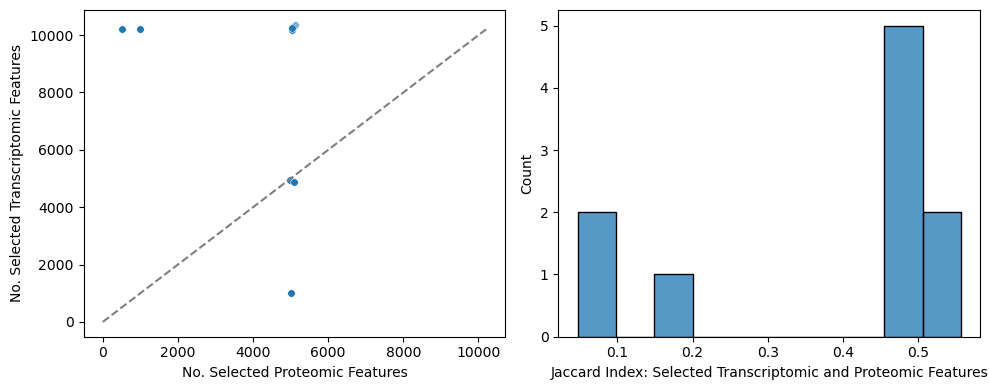

In [93]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

i = 0

sns.scatterplot(data = features_res, y = 'rna_jitter', x = 'prot_jitter', ax = ax[i], s = 30)
ax[i].plot([0, features_res[["n_features_Proteomics","n_features_Transcriptomics"]].max().max()],
         [0, features_res[["n_features_Proteomics","n_features_Transcriptomics"]].max().max()],
         '--', color='gray')


ax[i].set_ylabel('No. Selected Transcriptomic Features')
ax[i].set_xlabel('No. Selected Proteomic Features')

i = 1
sns.histplot(data = features_res, x = 'jaccard_index', ax = ax[i], bins = 10)
ax[i].set_xlabel('Jaccard Index: Selected Transcriptomic and Proteomic Features')

fig.tight_layout()

Left panel visualizes the selected features for a given fold in CV for either modality on the intersection of genes. Slight jitter is added to see non-unique combinations. In 3 folds the same # of features is selected, and in an additional 6, more transcriptomics features than proteomics is selected. Alongside performance results, this suggests that while similar information is present across modalities, transcriptomics information tends to be smoother across features; features may contribute weakly but additively. In contrast, proteomics has a lower effective dimensionality. 

The Jaccard Index indicates supports this notion --  when the same features are available, some selected features do overlap, but some do not. This indicates that the two modalities may carry both complementary and redundant information on phenotype in a feature-specific manner.

## Model Performance

Let's look at how the predictive performance of the two models when sharing common features is. 

We begin by getting consensus models:

In [94]:
best_pipeline_modality = {}
modality_types = ['Proteomics', 'Transcriptomics']
for modality in modality_types:
    print('--------------------{}--------------------'.format(modality.upper()))
    mask = (res_df.modality == modality)

        
    n_features_best = []
    C_best = []
    epsilon_best = []
    for k, bp in enumerate(res_df.loc[mask]['best_params']):
        n_features = int(bp.split(', ')[0].split(': ')[1])
        C = float(bp.split(', ')[1].split(': ')[1])
        epsilon = float(bp.split(', ')[2].split(': ')[1][:-1])

        n_features_best.append(n_features)
        C_best.append(C)
        epsilon_best.append(epsilon)    

        print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}'.format(k, n_features, C, epsilon))

    n_features_best = statistics.mode(n_features_best)
    C_best = np.mean(C_best)
    epsilon_best = np.mean(epsilon_best)

    print()
    print('The consensus model has features: {}, C: {:4f}, epsilon: {:.4f}'.format(n_features_best, C_best, epsilon_best))
    print()
    print()

    best_steps = [
        ("feature_reduction", feature_selector_map[modality](n_features = n_features_best)),
        ("mean_centering", MeanCenterer()),
    ]
    best_steps.append(("model", SVR(
        kernel='linear',
        C=C_best,
        epsilon=epsilon_best)
    ))

    best_pipeline_modality[modality] = Pipeline(best_steps)
print()



--------------------PROTEOMICS--------------------
Fold: 0, features: 5000, C: 18.853011, epsilon: 0.6511
Fold: 1, features: 5000, C: 21.384860, epsilon: 0.6438
Fold: 2, features: 5000, C: 0.370444, epsilon: 0.7805
Fold: 3, features: 5000, C: 5.064054, epsilon: 0.9753
Fold: 4, features: 5000, C: 4.173606, epsilon: 0.9790
Fold: 5, features: 5000, C: 34.413357, epsilon: 0.2844
Fold: 6, features: 500, C: 3.621986, epsilon: 1.1476
Fold: 7, features: 5000, C: 17.517576, epsilon: 1.4385
Fold: 8, features: 1000, C: 1.684146, epsilon: 0.7449
Fold: 9, features: 5000, C: 0.000149, epsilon: 0.0230

The consensus model has features: 5000, C: 10.708319, epsilon: 0.7668


--------------------TRANSCRIPTOMICS--------------------
Fold: 0, features: 1000, C: 0.160292, epsilon: 0.4880
Fold: 1, features: 5000, C: 8.139904, epsilon: 0.6676
Fold: 2, features: 10202, C: 0.129284, epsilon: 0.7836
Fold: 3, features: 5000, C: 7.202054, epsilon: 0.7511
Fold: 4, features: 10202, C: 0.019855, epsilon: 0.7002
Fold:

In [95]:
np.random.seed(random_state *4) # no CV
outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

fold_idx = {}
consensus_intersection_res = {'modality': [], 'fold': [], 'test_mse': [], 'test_corr': []}
for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X_protein, y_common))):
    fold_idx[k] = {'train_idx': train_idx.tolist(), 
                      'test_idx': test_idx.tolist()}
    
    y_train, y_test = y_common[train_idx], y_common[test_idx]

    
    X = {'Proteomics': {}, 
        'Transcriptomics': {}}

    X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
    X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]
    
    for modality in X:
        res_ = get_stats(
            best_pipeline_modality[modality], 
            y_train, 
            y_test,
            X[modality]['train'], 
            X[modality]['test'])
        train_corr, test_corr, train_mse, test_mse = res_
        
        consensus_intersection_res['modality'].append(modality)
        consensus_intersection_res['fold'].append(k)
        consensus_intersection_res['test_mse'].append(test_mse)
        consensus_intersection_res['test_corr'].append(test_corr)
        
consensus_intersection_res = pd.DataFrame(consensus_intersection_res)
consensus_intersection_res.modality = pd.Categorical(consensus_intersection_res.modality, 
                                           categories = ['Transcriptomics', 'Proteomics'], 
                                           ordered = True)


10it [00:29,  2.94s/it]


In [96]:
r_res = consensus_intersection_res[consensus_intersection_res.modality == 'Transcriptomics'].copy()
p_res = consensus_intersection_res[consensus_intersection_res.modality == 'Proteomics'].copy()


''

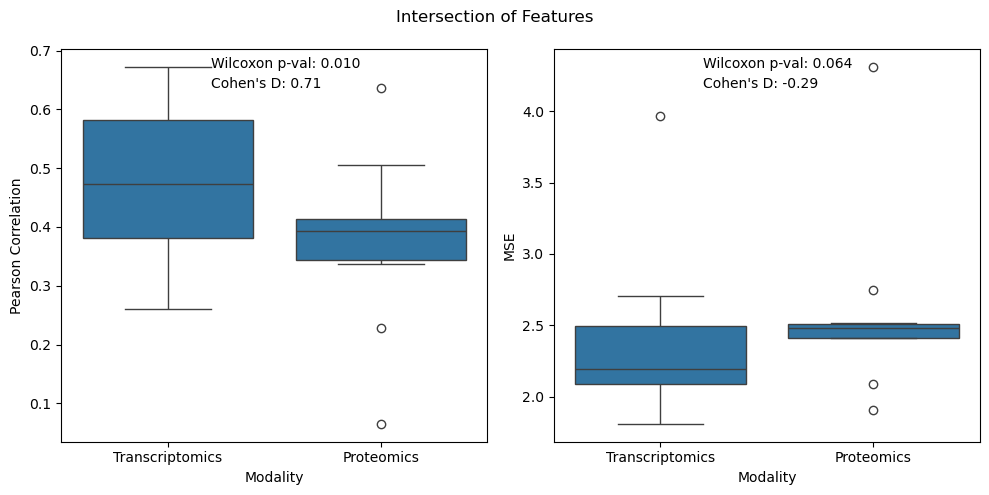

In [97]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))

res_stats_all = pd.DataFrame(columns = ['comparison', 'pval', 'cohend', 'metric'])
for i, metric in enumerate(metric_types):    
    sns.boxplot(data = consensus_intersection_res, x = 'modality', y = 'test_' + metric, ax = ax[i])
    
    pval = stats.wilcoxon(r_res['test_' + metric], p_res['test_' + metric]).pvalue
    cd = cohen_d(r_res['test_' + metric], p_res['test_' + metric])
    res_stats_all.loc[i, :] = [('Linear SVR - Transcriptomics', 'Linear SVR'), pval, cd, mmap[metric]]
    
    ax[i].annotate("Wilcoxon p-val: {:.3f}".format(pval), xy=(0.35, 0.95), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.35, 0.9), xycoords='axes fraction')
    
    ax[i].set_xlabel('Modality')
    ax[i].set_ylabel(mmap[metric])
    
res_stats_all.to_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_intersection.csv'))
fig.suptitle('Intersection of Features')

plt.savefig(os.path.join(data_path, 'figures', 'intersection_intersectioncomparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

fig.tight_layout()
;

**While p-values are significant, indicating that transcriptomics does outperform proteomics, the effect sizes are more moderate. MSE, which had the significant differences in Notebook 03, has a much smaller effect size. Pearson correlation, which did not have significant differences in Notebook 03, has a comparable moderate effect size.**

In [98]:
print('Mean, median, and std for transcriptomics, all features:')

for metric in ['test_mse', 'test_corr']:    
    print('Metric: {} | {:.2f}, {:.2f}, {:.2f}'.format(
        metric.split('_')[1], 
        r_res[metric].mean(), 
        r_res[metric].median(), 
        r_res[metric].std()

    ))

print('------------------------------------')
print('Mean, median, and std for proteomics, all features:')

for metric in ['test_mse', 'test_corr']:    
    print('Metric: {} | {:.2f}, {:.2f}, {:.2f}'.format(
        metric.split('_')[1], 
        p_res[metric].mean(), 
        p_res[metric].median(), 
        p_res[metric].std()

    ))

Mean, median, and std for transcriptomics, all features:
Metric: mse | 2.40, 2.19, 0.61
Metric: corr | 0.48, 0.47, 0.13
------------------------------------
Mean, median, and std for proteomics, all features:
Metric: mse | 2.59, 2.48, 0.65
Metric: corr | 0.37, 0.39, 0.15


When restricting both modalities to their shared gene set, the previously significant MSE advantage of transcriptomics disappears (P > 0.05), though it's near significant. Effect sizes also shrink relative to the full feature-set analysis, although they remain in the medium range. This indicates that a substantial portion of transcriptomics’ superior performance in the full model was due to its broader genome-wide coverage rather than an inherent superiority of the transcriptomic signal.

At the same time, the remaining medium effect size suggests that transcriptomics still gains modest benefit from having access to a less redundant feature space, consistent with our earlier observation that transcriptomics tends to distribute predictive signal across many features. These results imply that when proteomics captures a sufficiently rich and orthogonal subset of biologically relevant proteins, it can perform at least as well as transcriptomics.

## Consistency of Results

### Same 10-fold CV, all features

Let's ensure that, in contrast, on these 10-folds but each data modality using all features, the power analysis results demonstrating transcriptomics outperforms proteomics holds:

In [99]:
best_pipeline_rna = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline_protein = read_pickled_object(os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))

best_pipeline_modality = {
    'Transcriptomics': clone(best_pipeline_rna), 
    'Proteomics': clone(best_pipeline_protein)
}

X_rna = expr_rna_common.values.copy()
X_protein = expr_protein_common.values.copy()


In [100]:
consensus_all_res = {'modality': [], 'fold': [], 'test_mse': [], 'test_corr': []}
# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X_protein, y_common))):
for (k, splits) in tqdm(fold_idx.items()):
    
    train_idx = splits['train_idx']
    test_idx = splits['test_idx']

    y_train, y_test = y_common[train_idx], y_common[test_idx]

    X = {'Proteomics': {}, 
        'Transcriptomics': {}}

    X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
    X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]
    
    for modality in X:
        res_ = get_stats(
            best_pipeline_modality[modality], 
            y_train, 
            y_test,
            X[modality]['train'], 
            X[modality]['test'])
        train_corr, test_corr, train_mse, test_mse = res_
        
        consensus_all_res['modality'].append(modality)
        consensus_all_res['fold'].append(k)
        consensus_all_res['test_mse'].append(test_mse)
        consensus_all_res['test_corr'].append(test_corr)
        
consensus_all_res = pd.DataFrame(consensus_all_res)
consensus_all_res.modality = pd.Categorical(consensus_all_res.modality, 
                                           categories = ['Transcriptomics', 'Proteomics'], 
                                           ordered = True)

100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.50s/it]


In [101]:
r_res = consensus_all_res[consensus_all_res.modality == 'Transcriptomics'].copy()
p_res = consensus_all_res[consensus_all_res.modality == 'Proteomics'].copy()


''

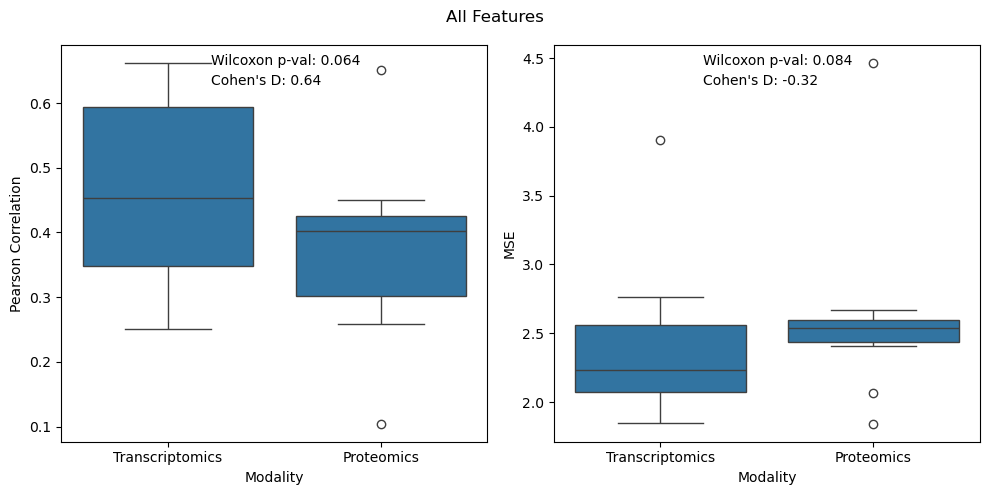

In [102]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))


for i, metric in enumerate(metric_types):    
    sns.boxplot(data = consensus_all_res, x = 'modality', y = 'test_' + metric, ax = ax[i])
    
    pval = stats.wilcoxon(r_res['test_' + metric], p_res['test_' + metric]).pvalue
    cd = cohen_d(r_res['test_' + metric], p_res['test_' + metric])
    
    ax[i].annotate("Wilcoxon p-val: {:.3f}".format(pval), xy=(0.35, 0.95), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.35, 0.9), xycoords='axes fraction')
    
    ax[i].set_xlabel('Modality')
    ax[i].set_ylabel(mmap[metric])
    
fig.suptitle('All Features')
plt.savefig(os.path.join(data_path, 'figures', 'intersection_unionncomparison.png'), 
            dpi=300, 
            bbox_inches="tight")  
fig.tight_layout()
;

In [103]:
print('Mean, median, and std for transcriptomics, all features:')

for metric in ['test_mse', 'test_corr']:    
    print('Metric: {} | {:.2f}, {:.2f}, {:.2f}'.format(
        metric.split('_')[1], 
        r_res[metric].mean(), 
        r_res[metric].median(), 
        r_res[metric].std()

    ))

print('------------------------------------')
print('Mean, median, and std for proteomics, all features:')

for metric in ['test_mse', 'test_corr']:    
    print('Metric: {} | {:.2f}, {:.2f}, {:.2f}'.format(
        metric.split('_')[1], 
        p_res[metric].mean(), 
        p_res[metric].median(), 
        p_res[metric].std()

    ))

Mean, median, and std for transcriptomics, all features:
Metric: mse | 2.41, 2.23, 0.59
Metric: corr | 0.47, 0.45, 0.15
------------------------------------
Mean, median, and std for proteomics, all features:
Metric: mse | 2.62, 2.54, 0.70
Metric: corr | 0.37, 0.40, 0.14


<span style="color:red">Smaller effect sizes, no significance</span>


In [104]:
import itertools
transcriptomics_power = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), index_col = 0)
transcriptomics_res = transcriptomics_power[transcriptomics_power.train_sample_size == len(common_samples)]

consensus_res_map = {'all': consensus_all_res, 
                'intersection': consensus_intersection_res}

In [105]:
metric_types = ['test_mse', 'test_corr']
modality_types = ['Proteomics', 'Transcriptomics']

n_subsets = 1000
N = 10   

bootstrap_idx = [
    np.random.choice(len(transcriptomics_res), size=N, replace=False)
    for _ in range(n_subsets)
]

null_vals = {}  
for metric_type in metric_types:
    null_metric = transcriptomics_res[metric_type].values 
    vals_for_metric = []
    for idx in bootstrap_idx:
        vals_for_metric.append(np.median(null_metric[idx]))

    null_vals[metric_type] = np.array(vals_for_metric)

val_stats = {'feature_type': [], 'metric_type': [], 'modality': [], 'pval': []}
for crt, metric, modality in itertools.product(consensus_res_map, metric_types, modality_types):
    consensus_res = consensus_res_map[crt].copy()
    mask = (consensus_res.modality == modality)
    consensus_res = consensus_res.loc[mask]

    actual_val = np.median(consensus_res[metric_type])

    
    # test whether median performance is better than transcriptomic power analysis
    
    if metric_type == 'test_mse': # one-sided p-value: actual_val > null
        pval = (null_vals[metric_type] <= actual_val).mean()
    else: # one-sided p-value: actual_val < null
        pval = (null_vals[metric_type] >= actual_val).mean()

    val_stats['feature_type'].append(crt)
    val_stats['modality'].append(modality)
    val_stats['metric_type'].append(metric_type)
    val_stats['pval'].append(pval)

val_stats = pd.DataFrame(val_stats)


# val_stats['fdr'] = np.nan

# for metric_type in metric_types_:
#     mask = val_stats['metric_type'] == metric_type
#     pvals = val_stats.loc[mask, 'pval'].values
#     _, fdr_corr, _, _ = multipletests(pvals, method='fdr_bh')

#     val_stats.loc[mask, 'fdr'] = fdr_corr

# val_stats = val_stats.sort_values(by = ['metric_type', 'model_type']).reset_index(drop = True)
# val_stats

In [106]:
val_stats

,feature_type,metric_type,modality,pval
0,all,test_corr,Proteomics,0.740
1,all,test_corr,Transcriptomics,0.376
2,all,test_corr,Proteomics,0.740
3,all,test_corr,Transcriptomics,0.376
4,intersection,test_corr,Proteomics,0.800
5,intersection,test_corr,Transcriptomics,0.228
6,intersection,test_corr,Proteomics,0.800
7,intersection,test_corr,Transcriptomics,0.228


# you are here

## 2.2 Top Features Comparison

Let's also compare the extent to which top-ranked features agree when we use just the intersection of features.

In [ ]:
res_df = pd.read_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv'), 
                    index_col = 0)
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])

r_res = res_df[res_df.modality == 'Transcriptomics']
p_res = res_df[res_df.modality == 'Proteomics']

X_protein = expr_protein_common[protein_cols_intersect].copy().values
X_rna = expr_rna_common[rna_cols_intersect].copy().values

In [ ]:
n_features_best = []
C_best = []
epsilon_best = []
for bp in r_res.best_params:
    print(bp)
    print('------------------------------------------------------')
    bp = eval(bp)
    n_features_best.append(bp['FeatureSelector__n_features'])
    C_best.append(bp['SVR_linear__C'])
    epsilon_best.append(bp['SVR_linear__epsilon'])
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = sorted(pd.Series(n_features_best).mode())[0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))

best_intersection_pipeline_rna = Pipeline(best_steps)
best_intersection_pipeline_rna

In [ ]:
n_features_best = []
C_best = []
epsilon_best = []
for bp in p_res.best_params:
    print(bp)
    print('------------------------------------------------------')
    bp = eval(bp)
    n_features_best.append(bp['FeatureSelector__n_features'])
    C_best.append(bp['SVR_linear__C'])
    epsilon_best.append(bp['SVR_linear__epsilon'])
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = sorted(pd.Series(n_features_best).mode())[0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))

best_intersection_pipeline_protein = Pipeline(best_steps)
best_intersection_pipeline_protein

In [ ]:
best_intersection_pipeline_protein.fit(X_protein, y_common)
best_intersection_pipeline_rna.fit(X_rna, y_common)

In [ ]:
model_coefs_protein = get_ranked_coefs(best_intersection_pipeline_protein, protein_map, protein_cols)
model_coefs_rna = get_ranked_coefs(best_intersection_pipeline_rna, rna_map, rna_cols)

In [ ]:
model_coefs_protein.Gene_Name.tolist() + 

In [ ]:
[total_features - model_coefs_protein.shape[0]

In [ ]:
i = 3000

In [ ]:
total_features = max(model_coefs_protein.shape[0], model_coefs_rna.shape[0])
viz_df = pd.DataFrame(data = {
    'Rank': list(range(1, total_features + 1)), 
    'RNA': model_coefs_rna.Gene_Name.tolist() + [np.nan]*(total_features - model_coefs_rna.shape[0]), 
    'Protein': model_coefs_protein.Gene_Name.tolist() + [np.nan]*(total_features - model_coefs_protein.shape[0])
})

fraction_overlap = []
for i in tqdm(viz_df.index):
    proteins = set(viz_df.loc[:i, 'Protein'][viz_df.loc[:i, 'Protein'].notna()])
    rnas = set(viz_df.loc[:i, 'RNA'][viz_df.loc[:i, 'RNA'].notna()])
    
    fraction_overlap.append(float(len(set(proteins).intersection(rnas))/viz_df.loc[i, 'Rank']))
viz_df['fraction_overlap'] = fraction_overlap

In [ ]:
sns.lineplot(data = viz_df, x = 'Rank', y = 'fraction_overlap')